In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import OneHotEncoder
from six.moves import cPickle

/Users/GYUNAM/.pyenv/versions/3.4.5/lib/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)


In [2]:
x = cPickle.load(open('./data_files/x.pkl', 'rb'))
y = cPickle.load(open('./data_files/y.pkl', 'rb'))

In [3]:

x.shape

(124800, 784)

In [4]:
y.shape


(124800,)

In [5]:
# one-hot encoding

ohe = OneHotEncoder()
ohe.fit(y.reshape(-1, 1))
y = ohe.transform(y.reshape(-1,1)).toarray()

In [6]:
y.shape

(124800, 26)

In [7]:
# Split training data
train_x = x[0:80000, :] 
train_y = y[0:80000, :] 

train_x = train_x.reshape(train_x.shape[0], 28, 28, order='A')
train_y = train_y.reshape(train_y.shape[0], 26)

In [8]:
# Split test data
test_x = x[80000:85000, :]
test_y = y[80000:85000, :]

test_x = test_x.reshape(test_x.shape[0], 28, 28, order='A')
test_y = test_y.reshape(test_y.shape[0], 26)

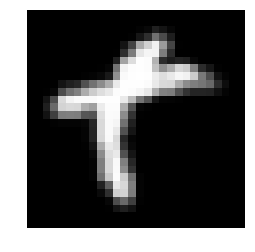

In [9]:
idx = np.random.randint(len(test_x))
img = train_x[idx]
plt.imshow(img, 'gray')
plt.axis('off')
plt.show()

In [45]:
input_h = 28 # Input height
input_w = 28 # Input width
input_ch = 1 # Input channel : Gray scale
# (None, 28, 28, 1)

## First convolution layer
# Filter size
k1_h = 3
k1_w = 3
# the number of channels
k1_ch = 32
# Pooling size
p1_h = 2
p1_w = 2
# (None, 14, 14 ,32)

## Second convolution layer
# Filter size
k2_h = 3
k2_w = 3
# the number of channels
k2_ch = 64
# Pooling size
p2_h = 2
p2_w = 2
# (None, 7, 7 ,64)

## Fully connected
# Flatten the features
# -> (None, 7*7*64)
conv_result_size = int((input_h/(p1_h*p2_h)) * (input_w/(p1_w*p2_w)) * k2_ch)
n_hidden1 = 100
n_output = 26

In [46]:
weights = {
    'conv1' : tf.Variable(tf.random_normal([k1_h, k1_w, input_ch, k1_ch],stddev = 0.1)),
    'conv2' : tf.Variable(tf.random_normal([k2_h, k2_w, k1_ch, k2_ch],stddev = 0.1)),
    'hidden1' : tf.Variable(tf.random_normal([conv_result_size, n_hidden1], stddev = 0.1)),
    'output' : tf.Variable(tf.random_normal([n_hidden1, n_output], stddev = 0.1))
}

biases = {
    'conv1' : tf.Variable(tf.random_normal([k1_ch], stddev = 0.1)),
    'conv2' : tf.Variable(tf.random_normal([k2_ch], stddev = 0.1)),
    'hidden1' : tf.Variable(tf.random_normal([n_hidden1], stddev = 0.1)),
    'output' : tf.Variable(tf.random_normal([n_output], stddev = 0.1))
}

x = tf.placeholder(tf.float32, [None, input_h, input_w, input_ch])
y = tf.placeholder(tf.float32, [None, n_output])

In [47]:
# Define Network
def net(x, weights, biases):
    ## First convolution layer
    conv1 = tf.nn.conv2d(x, weights['conv1'], 
                         strides= [1, 1, 1, 1], 
                         padding = 'SAME')
    conv1 = tf.nn.relu(tf.add(conv1, biases['conv1']))
    maxp1 = tf.nn.max_pool(conv1, 
                           ksize = [1, p1_h, p1_w, 1], 
                           strides = [1, p1_h, p1_w, 1], 
                           padding = 'VALID'
                           )
    
    ## Second convolution layer
    conv2 = tf.nn.conv2d(maxp1, weights['conv2'], 
                         strides= [1, 1, 1, 1], 
                         padding = 'SAME')
    conv2 = tf.nn.relu(tf.add(conv2, biases['conv2']))
    maxp2 = tf.nn.max_pool(conv2, 
                           ksize = [1, p2_h, p2_w, 1], 
                           strides = [1, p2_h, p2_w, 1], 
                           padding = 'VALID')

    # shape = conv2.get_shape().as_list()
    # maxp2_re = tf.reshape(conv2, [-1, shape[1]*shape[2]*shape[3]])
    maxp2_re = tf.reshape(maxp2, [-1, conv_result_size])
    
    ### Fully connected
    hidden1 = tf.add(tf.matmul(maxp2_re, weights['hidden1']), biases['hidden1'])
    hidden1 = tf.nn.relu(hidden1)
    output = tf.add(tf.matmul(hidden1, weights['output']), biases['output'])
    return output

In [51]:
LR = 0.01

pred = net(x, weights, biases)
loss = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)
loss = tf.reduce_mean(loss)

# optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
optm = tf.train.AdamOptimizer(LR).minimize(loss)

init = tf.global_variables_initializer()

In [52]:
n_batch = 50
n_iter = 5000
n_prt = 250

In [53]:
# Run initialize
# config = tf.ConfigProto(allow_soft_placement=True)  # GPU Allocating policy
# sess = tf.Session(config=config)
sess = tf.Session()
sess.run(init)

# Training cycle
for epoch in range(n_iter):
    idx = np.random.randint(len(train_x), size= n_batch)
    train_x2 = [train_x[i] for i in idx]
    train_y2 = [train_y[i] for i in idx]
    train_x2 = np.reshape(train_x2, [-1, input_h, input_w, input_ch])
    sess.run(optm, feed_dict={x: train_x2,  y: train_y2})
    
    if epoch % n_prt == 0:
        c = sess.run(loss, feed_dict={x: train_x2, y: train_y2})
        print ("Iter : {}".format(epoch))
        print ("Cost : {}".format(c))

Iter : 0
Cost : 1035.2093505859375
Iter : 250
Cost : 0.9806426167488098
Iter : 500
Cost : 0.8601124286651611
Iter : 750
Cost : 0.2676442861557007
Iter : 1000
Cost : 0.8401616811752319
Iter : 1250
Cost : 0.43720775842666626
Iter : 1500
Cost : 0.6187094449996948
Iter : 1750
Cost : 0.3431769907474518
Iter : 2000
Cost : 0.7453379034996033
Iter : 2250
Cost : 0.34709540009498596
Iter : 2500
Cost : 0.4573918581008911
Iter : 2750
Cost : 0.5755653977394104
Iter : 3000
Cost : 0.31446707248687744
Iter : 3250
Cost : 0.5501164793968201
Iter : 3500
Cost : 0.5114644765853882
Iter : 3750
Cost : 0.33609911799430847
Iter : 4000
Cost : 0.5946319103240967
Iter : 4250
Cost : 0.6089591979980469
Iter : 4500
Cost : 0.47885993123054504
Iter : 4750
Cost : 0.4916156530380249


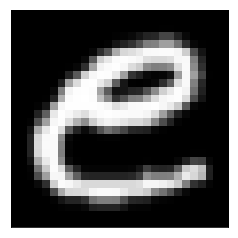

Prediction : 4
Label : 4


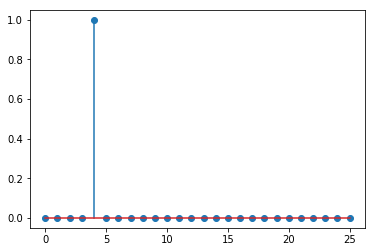

In [55]:
idx = np.random.randint(len(test_x),size=1)
test_x2 = [test_x[i] for i in idx]
test_y2 = [test_y[i] for i in idx]
logits = sess.run(tf.nn.softmax(pred), feed_dict={x : np.array(test_x2).reshape(-1, 28, 28, 1)})
predict = np.argmax(logits)

plt.imshow(np.array(test_x2).reshape(28, 28), 'gray')
plt.xticks([])
plt.yticks([])
plt.show()

print('Prediction : {}'.format(predict))
print('Label : {}'.format(np.argmax(test_y2)))

plt.stem(logits.ravel())
plt.show()